In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import library yang dibutuhkan
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
# Membaca dan merubah dataset menjadi sebuah dataframe
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/weather_data_kolkata_2015_2020.csv")

In [ ]:
# Menampilkan 5 dataframe teratas
df.head()

,DATETIME,TEMPERATURE,HUMIDITY
0,2015-01-01 00:00:00,19.0,75.0
1,2015-01-01 01:00:00,19.0,77.0
2,2015-01-01 02:00:00,19.0,78.0
3,2015-01-01 03:00:00,19.0,80.0
4,2015-01-01 04:00:00,19.0,81.0


In [ ]:
# Menampilkan dataframe terakhir
df.tail

<bound method NDFrame.tail of                   DATETIME  TEMPERATURE  HUMIDITY
0      2015-01-01 00:00:00         19.0      75.0
1      2015-01-01 01:00:00         19.0      77.0
2      2015-01-01 02:00:00         19.0      78.0
3      2015-01-01 03:00:00         19.0      80.0
4      2015-01-01 04:00:00         19.0      81.0
...                    ...          ...       ...
52603  2020-12-31 19:00:00         25.0      36.0
52604  2020-12-31 20:00:00         24.0      37.0
52605  2020-12-31 21:00:00         23.0      38.0
52606  2020-12-31 22:00:00         22.0      39.0
52607  2020-12-31 23:00:00         21.0      40.0

[52608 rows x 3 columns]>

In [ ]:
# Cek apakah dataset terdapat nilai yang kosong
df.isnull().sum()

DATETIME       0
TEMPERATURE    0
HUMIDITY       0
dtype: int64

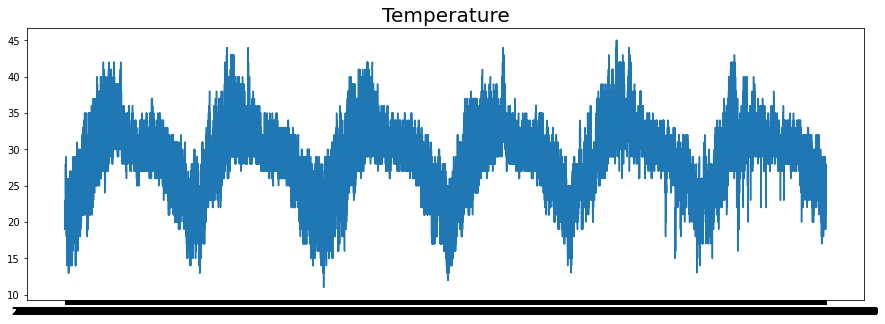

In [ ]:
# Membuat plot dari data
dates = df['DATETIME'].values
temp  = df['TEMPERATURE'].values

plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature',
          fontsize=20);

In [ ]:
# Membagi data untuk training dan data untuk testing dengan Validation set sebesar 20% dari total dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(temp, dates, test_size = 0.2, shuffle = False )

print('Total Data Train: ',len(x_train))
print('Total Data Test: ',len(x_test))

Total Data Train:  42086
Total Data Test:  10522


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
# Membuat model dengan menggunakan model sequential dan LSTM

tf.keras.backend.set_floatx('float32')

train_set = windowed_dataset(x_train, window_size=60, batch_size=200, shuffle_buffer=1000)
test_set = windowed_dataset(x_test, window_size=64, batch_size=200, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
# Mencari nilai MAE dari model < 10% skala data
MAE = (df['TEMPERATURE'].max() - df['TEMPERATURE'].min()) * 0.1
print(MAE)

3.4000000000000004


In [ ]:
# Penggunaan parameter learning rate dan momentum pada optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
# Penggunaan callbacks
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < 3.4000000000000004 and logs.get('val_mae') < 3.4000000000000004):
      print("Training dihentikan karena MAE dari model < 10% skala data")
      self.model.stop_training = True

callbacks = Callback()

In [ ]:
# Pelatihan model
history = model.fit(train_set,epochs=30, validation_data = test_set, batch_size=128, shuffle=False, callbacks=[callbacks])

Epoch 1/30
211/211 [==============================] - 52s 223ms/step - loss: 25.5669 - mae: 26.0669 - val_loss: 21.3385 - val_mae: 21.8385
Epoch 2/30
211/211 [==============================] - 46s 217ms/step - loss: 8.1374 - mae: 8.6223 - val_loss: 3.8278 - val_mae: 4.3082
Epoch 3/30
211/211 [==============================] - 48s 225ms/step - loss: 4.0805 - mae: 4.5563 - val_loss: 3.6309 - val_mae: 4.1118
Epoch 4/30
211/211 [==============================] - 46s 219ms/step - loss: 3.9967 - mae: 4.4724 - val_loss: 3.6162 - val_mae: 4.0960
Epoch 5/30
211/211 [==============================] - 47s 220ms/step - loss: 3.9075 - mae: 4.3836 - val_loss: 3.4491 - val_mae: 3.9281
Epoch 6/30
211/211 [==============================] - 47s 221ms/step - loss: 3.8402 - mae: 4.3162 - val_loss: 3.4113 - val_mae: 3.8898
Epoch 7/30
211/211 [==============================] - 47s 222ms/step - loss: 3.7797 - mae: 4.2548 - val_loss: 3.3453 - val_mae: 3.8229
Epoch 8/30
211/211 [==============================]

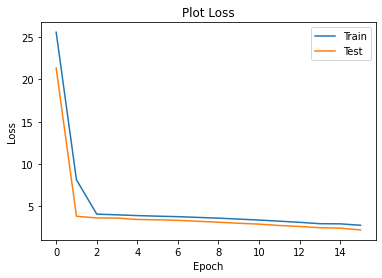

In [ ]:
# Visualisasi plot loss saat training dan validation
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Plot Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

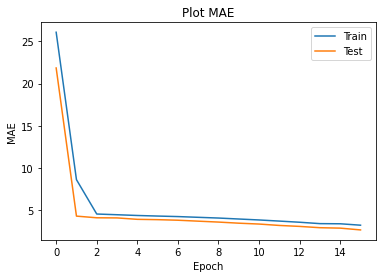

In [ ]:
# Visualisasi plot MAE saat training dan validation
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Plot MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
Sumber dataset: https://www.kaggle.com/sumandey/temperature-and-humidity-of-kolkata-from-20152020